### TIME SERIES FORECASTING

#### 1. Import Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#### 2. Load Dataset

In [9]:
data = pd.read_csv(r"C:\Users\srira\Downloads\OPTIFYX INTERNSHIP 2\AEP_hourly.csv")
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)

#### 3. Data Analysis

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


In [11]:
data.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [13]:
data.columns

Index(['AEP_MW'], dtype='object')

In [14]:
# Check for missing values
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 AEP_MW    0
dtype: int64


#### 4. Data Preprocessing

In [15]:
# Resample data to daily mean for simplicity
resampled_data = data['AEP_MW'].resample('D').mean()
train, test = resampled_data[:int(0.8*len(resampled_data))], resampled_data[int(0.8*len(resampled_data)):]

#### 5. Data Visualization

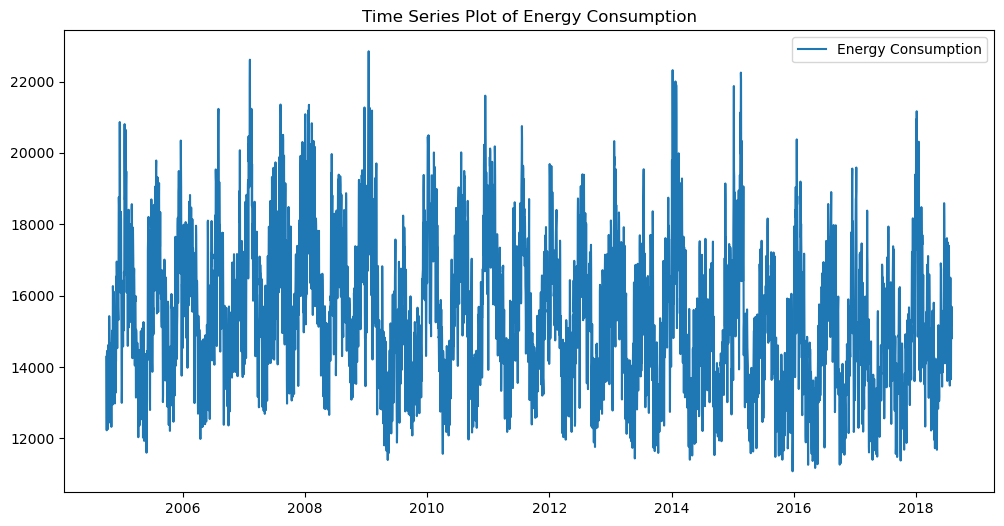

In [16]:
# Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(resampled_data, label='Energy Consumption')
plt.title('Time Series Plot of Energy Consumption')
plt.legend()
plt.show()

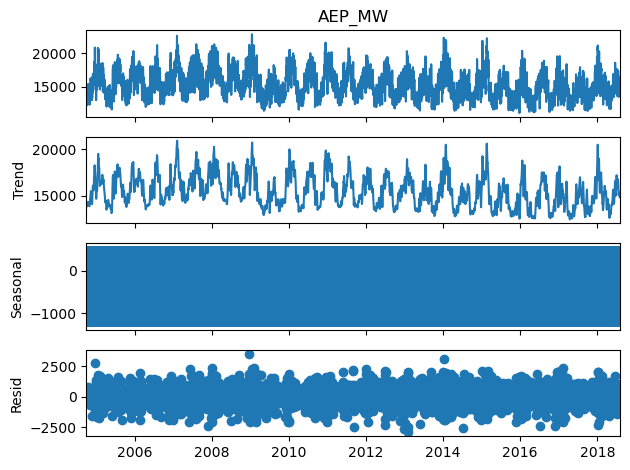

In [17]:
# Seasonal Decomposition
decomposition = seasonal_decompose(resampled_data, model='additive')
decomposition.plot()
plt.show()

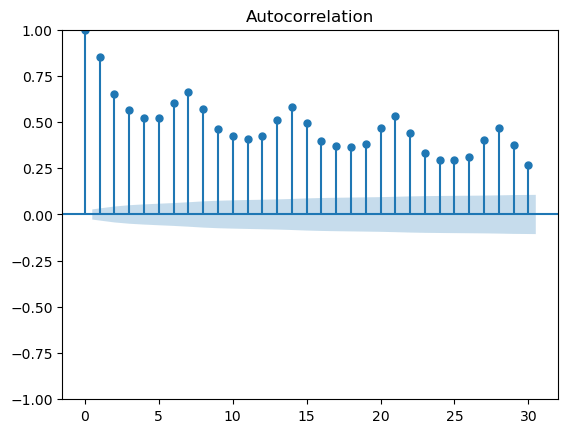

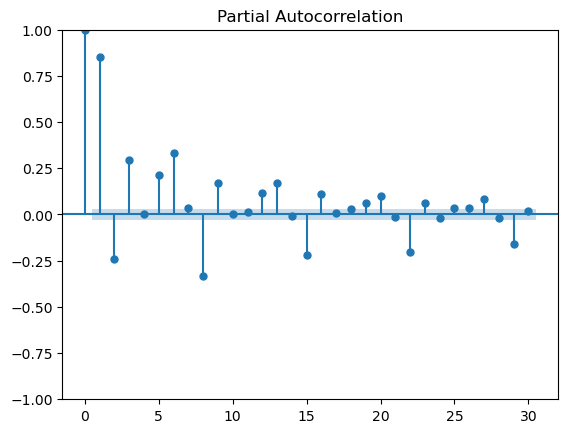

In [18]:
# Autocorrelation and Partial Autocorrelation
plot_acf(resampled_data.dropna(), lags=30)
plt.show()
plot_pacf(resampled_data.dropna(), lags=30)
plt.show()

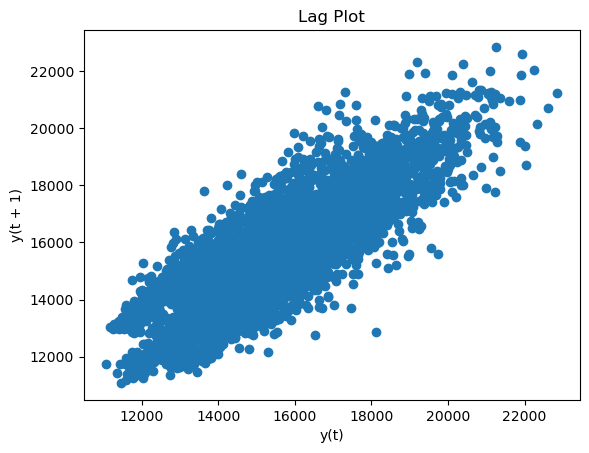

In [19]:
# Lag Plot
pd.plotting.lag_plot(resampled_data.dropna())
plt.title("Lag Plot")
plt.show()

#### 6. Model Training

In [20]:
# XGBoost Regressor
x_train, x_test, y_train, y_test = train_test_split(
    np.arange(len(train)).reshape(-1, 1), train.values, test_size=0.2, random_state=42
)
xgb_model = XGBRegressor()
xgb_model.fit(x_train, y_train)
xgb_predictions = xgb_model.predict(x_test)

In [21]:
# ARIMA
arima_model = ARIMA(train, order=(5, 1, 2))
arima_fit = arima_model.fit()
arima_predictions = arima_fit.forecast(steps=len(test))

C:\Users\srira\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
# LSTM
train_scaled = (train - train.min()) / (train.max() - train.min())
train_seq = np.array([train_scaled.values[i-10:i] for i in range(10, len(train_scaled))])
train_target = train_scaled.values[10:]
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(10, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(train_seq.reshape(-1, 10, 1), train_target, epochs=10, verbose=0)
lstm_predictions = lstm_model.predict(np.array([train_scaled.values[-10:]]).reshape(-1, 10, 1))
lstm_predictions = lstm_predictions.flatten() * (train.max() - train.min()) + train.min()

C:\Users\srira\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


#### 7. Evaluate the Models

In [23]:
# XGBoost Metrics
rmse_xgb = mean_squared_error(y_test, xgb_predictions, squared=False)
mae_xgb = mean_absolute_error(y_test, xgb_predictions)
mape_xgb = np.mean(np.abs((y_test - xgb_predictions) / y_test)) * 100
r2_xgb = r2_score(y_test, xgb_predictions)

In [24]:
print("XGBoost Performance:")
print(f"RMSE: {rmse_xgb}, MAE: {mae_xgb}, MAPE: {mape_xgb}, R2: {r2_xgb}")

XGBoost Performance:
RMSE: 1300.3482576787944, MAE: 1031.6024861065391, MAPE: 6.60398980763382, R2: 0.5705906102286809


In [25]:
# ARIMA Metrics
rmse_arima = mean_squared_error(test, arima_predictions, squared=False)
mae_arima = mean_absolute_error(test, arima_predictions)
mape_arima = np.mean(np.abs((test.values - arima_predictions) / test.values)) * 100
r2_arima = r2_score(test, arima_predictions)

In [26]:
print("\nARIMA Performance:")
print(f"RMSE: {rmse_arima}, MAE: {mae_arima}, MAPE: {mape_arima}, R2: {r2_arima}")


ARIMA Performance:
RMSE: 2379.8751532199935, MAE: 1826.5744893114081, MAPE: 11.525358201127222, R2: -0.7069660721130542
